C:\Users\Sagar Paul\AppData\Local\Temp\ipykernel_34504\3190676375.py:27: DtypeWarning: Columns (29,30,31,32,33,34,35,36,37,38,39,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("US_Accidents_March23.csv")


Data loaded successfully!
          ID   Source  Severity          Start_Time            End_Time  \
0   A-636616  Source2         2 2022-04-27 07:42:29 2022-04-27 08:27:46   
1   A-762201  Source3         2 2021-12-28 15:57:12 2021-12-28 18:31:05   
2   A-849168  Source2         3 2021-10-23 15:30:17 2021-10-23 17:14:31   
3   A-719224  Source2         2 2022-02-07 16:15:17 2022-02-07 16:59:01   
4  A-1284101  Source2         2 2020-11-03 07:02:17 2020-11-03 08:02:18   

   Start_Lat  Start_Lng  End_Lat  End_Lng  Distance(mi)  ... Roundabout  \
0  41.264488 -73.529701      NaN      NaN           0.0  ...      False   
1  41.189251 -77.230240      NaN      NaN           0.0  ...      False   
2  35.217800 -80.871933      NaN      NaN           0.0  ...      False   
3  40.584129 -73.986710      NaN      NaN           0.0  ...      False   
4  32.827602 -86.624527      NaN      NaN           0.0  ...      False   

  Station   Stop Traffic_Calming Traffic_Signal Turning_Loop Sunrise_Sun

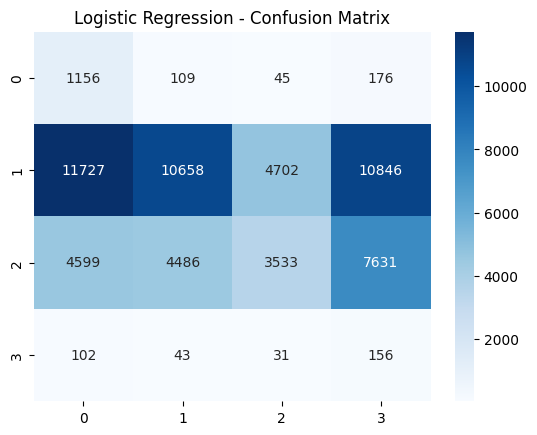


Training Random Forest...
Random Forest Accuracy: 0.5945666666666667
Random Forest F1 Score: 0.3278798441023707
              precision    recall  f1-score   support

           0       0.16      0.18      0.17      1486
           1       0.68      0.72      0.70     37933
           2       0.45      0.39      0.42     20249
           3       0.03      0.02      0.02       332

    accuracy                           0.59     60000
   macro avg       0.33      0.33      0.33     60000
weighted avg       0.58      0.59      0.59     60000



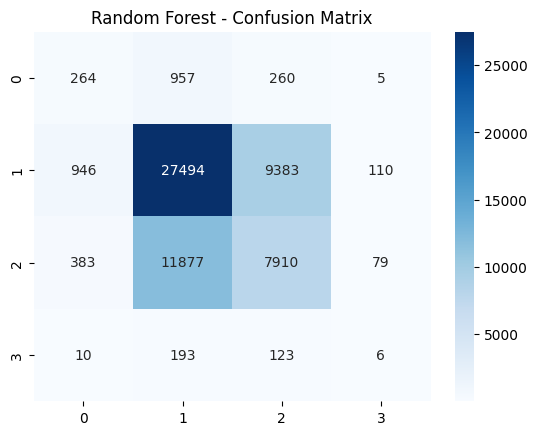


Training XGBoost...
XGBoost Accuracy: 0.5934166666666667
XGBoost F1 Score: 0.3376848609908027
              precision    recall  f1-score   support

           0       0.15      0.55      0.23      1486
           1       0.68      0.75      0.71     37933
           2       0.50      0.32      0.39     20249
           3       0.03      0.01      0.01       332

    accuracy                           0.59     60000
   macro avg       0.34      0.41      0.34     60000
weighted avg       0.60      0.59      0.59     60000



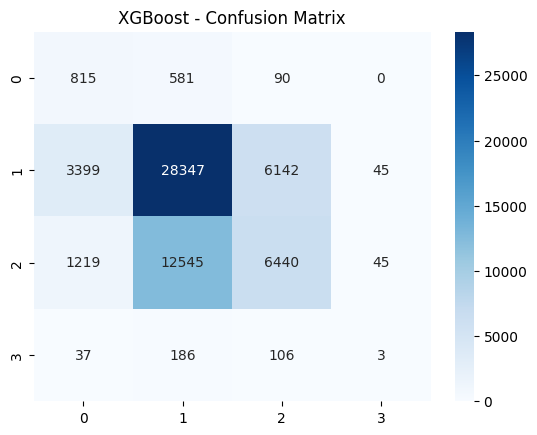


Model saved as best_accident_severity_model.joblib


In [ ]:
# -----------------------------------
# 1) IMPORTS
# -----------------------------------
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline


# -----------------------------------
# 2) LOAD DATA (YOUR FILE)
# -----------------------------------
df = pd.read_csv("US_Accidents_March23.csv")

# Force datetime conversion for your columns
df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
df['End_Time']   = pd.to_datetime(df['End_Time'], errors='coerce')

# Drop rows where Start_Time is invalid
df = df.dropna(subset=['Start_Time'])
#Limit Data as the data is huge
df = df.sample(300000, random_state=42).reset_index(drop=True)

print("Data loaded successfully!")
print(df.head())
print(df.info())


# -----------------------------------
# 3) FEATURE ENGINEERING
# -----------------------------------
df['hour'] = df['Start_Time'].dt.hour
df['weekday'] = df['Start_Time'].dt.dayofweek   # Mon=0
df['month'] = df['Start_Time'].dt.month
df['is_weekend'] = df['weekday'].isin([5,6]).astype(int)
df['rush_hour'] = df['hour'].isin([7,8,9,16,17,18]).astype(int)

# Simplify Weather condition column
df['Weather_Condition'] = df['Weather_Condition'].astype(str).str.lower()

def simplify_weather(w):
    if "rain" in w or "drizzle" in w:
        return "rain"
    if "snow" in w:
        return "snow"
    if "fog" in w:
        return "fog"
    if "clear" in w or "sun" in w:
        return "clear"
    return "other"

df['weather_simple'] = df['Weather_Condition'].apply(simplify_weather)


# -----------------------------------
# 4) SELECT FEATURES + TARGET
# -----------------------------------
features = [
    'hour', 'weekday', 'month',
    'is_weekend', 'rush_hour', 'weather_simple',
    'Visibility(mi)', 'Temperature(F)', 'Wind_Speed(mph)'
]

X = df[features]
#rows limit actaully 1 2 3 0-2 -1
y = df['Severity'].astype(int)-1


# -----------------------------------
# 5) TRAIN TEST SPLIT
# -----------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


# -----------------------------------
# 6) PREPROCESSING PIPELINES
# -----------------------------------
numeric_features = ['Visibility(mi)', 'Temperature(F)', 'Wind_Speed(mph)', 'hour', 'weekday', 'month']
categorical_features = ['weather_simple', 'is_weekend', 'rush_hour']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)


# -----------------------------------
# 7) MODEL TRAINING FUNCTION
# -----------------------------------
def train_model(model, name):
    print(f"\nTraining {name}...")
    
    pipe = ImbPipeline(steps=[
        ('preproc', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('clf', model)
    ])
    
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)

    print(f"{name} Accuracy:", accuracy_score(y_test, preds))
    print(f"{name} F1 Score:", f1_score(y_test, preds, average='macro'))
    print(classification_report(y_test, preds))

    cm = confusion_matrix(y_test, preds)
    sns.heatmap(cm, annot=True, cmap="Blues", fmt='d')
    plt.title(f"{name} - Confusion Matrix")
    plt.show()

    return pipe


# -----------------------------------
# 8) TRAIN MODELS
# -----------------------------------
lr_model = train_model(LogisticRegression(max_iter=2000), "Logistic Regression")
rf_model = train_model(RandomForestClassifier(n_estimators=250), "Random Forest")
xgb_model = train_model(xgb.XGBClassifier(eval_metric='mlogloss'), "XGBoost")


# -----------------------------------
# 9) SAVE BEST MODEL (CHOOSE XGBOOST)
# -----------------------------------
joblib.dump(xgb_model, "best_accident_severity_model.joblib")
print("\nModel saved as best_accident_severity_model.joblib")
